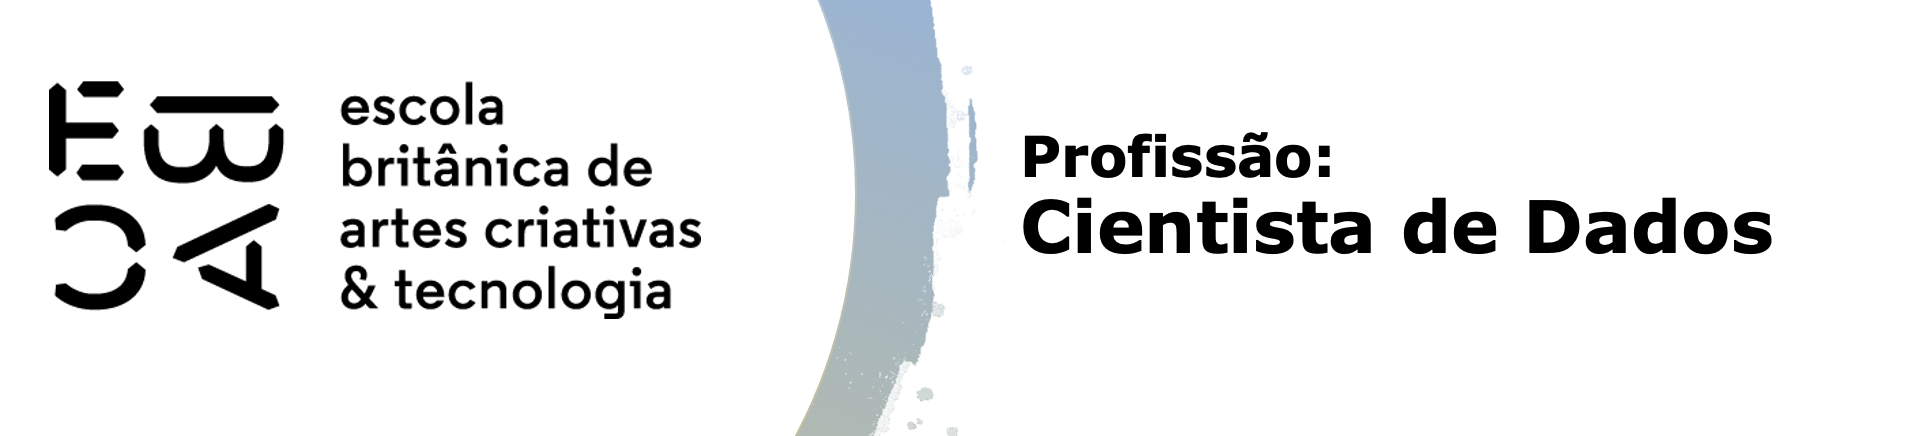

# Árvores II - Tarefa 3

### 1. Carregar as bases

Vamos utilizar nesta tarefa as bases de reconhecimento de atividade humana através do celular. Carregue novamente as bases salvas na tarefa I.

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

In [2]:
X_treino = pd.read_csv('X_train.csv')
X_teste = pd.read_csv('X_test.csv')
y_treino = pd.read_csv('y_train.csv')
y_teste = pd.read_csv('y_test.csv')

### 2. Calcule os ```ccp_alphas```. 

Vamos seguir uma lógica bem em linha com o que já estamso acostumados, com as seguintes orientações:

- Utilizar treinamento e teste conforme já vieram definidos originalmente
- Por pragmatismo, utilizar ```min_samples_leaf=20```
- Utilize as mesmas "3 melhores variáveis" identificadas no exercício anterior.

In [3]:
%%time
X_train, X_valid, y_train, y_valid = train_test_split(X_treino, y_treino, test_size=0.25, random_state=5)

CPU times: total: 0 ns
Wall time: 22 ms


In [4]:
X_teste['Subject'] = 0  # Adiciona a coluna 'Subject' com todos os valores iguais a 0

In [5]:
# Substituir infinitos por NaN e verificar se ainda existem valores infinitos
X_treino.replace([np.inf, -np.inf], np.nan, inplace=True)
assert not np.isinf(X_treino.values).any(), "Ainda existem valores infinitos."

# Preencher NaNs com 0 (confirmar que todas as entradas são tratadas)
X_treino.fillna(0, inplace=True)
assert not X_treino.isna().any().any(), "Ainda existem valores NaN após preenchimento."

# Converter tipos, assegurando que todos são float32
X_treino = X_treino.astype('float32')
assert X_treino.dtypes.unique()[0] == np.float32, "Problemas na conversão para float32."

# Verificar explicitamente se há valores ausentes ou infinitos após todas as conversões
assert not np.isnan(X_treino.values).any(), "Existem NaNs nos dados."
assert not np.isinf(X_treino.values).any(), "Existem infinitos nos dados."

In [6]:
def clean_data(df):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinities
    df.fillna(0, inplace=True)                           # Fill NaNs with zero
    df = df.astype('float32')                            # Convert types to float32
    assert not np.isnan(df.values).any(), "NaNs present in the data."
    assert not np.isinf(df.values).any(), "Infinities present in the data."
    return df

# Apply cleaning to all datasets
X_treino = clean_data(pd.read_csv('X_train.csv'))
X_teste = clean_data(pd.read_csv('X_test.csv'))
y_treino = pd.read_csv('y_train.csv')
y_teste = pd.read_csv('y_test.csv')

# Splitting the data
X_train, X_valid, y_train, y_valid = train_test_split(X_treino, y_treino, test_size=0.25, random_state=5)

# Add 'Subject' column if needed
X_teste['Subject'] = 0

In [7]:
clf = DecisionTreeClassifier(max_depth=4, random_state=5, min_samples_leaf=20)
clf.fit(X_train, y_train)
importances = clf.feature_importances_

# Obtendo os índices das três variáveis mais importantes
indices = np.argsort(importances)[::-1][:3]

# Printar as três variáveis mais importantes
for i in indices:
    print(f"Variável {X_treino.columns[i]}: Importância {importances[i]:.4f}")

Variável Unnamed: 52: Importância 0.2810
Variável Unnamed: 381: Importância 0.2564
Variável Unnamed: 41: Importância 0.1658


### 3. *Grid Search*

Vou deixar especificações iniciais mínimas, que visam limitar o tempo de máquina, pois um procedimento desses pode demorar muito tempo dependendo da especificação. Mas conforme você for ficando confortável com o tempo consumido pelo procedimento, pode fazer um algoritmo mais exaustivo, por exemplo, avaliando mais valores de ```ccp_alpha```.

- Meça o tempo
- Utilize a base de treinamento
- Utilize um *cross validation* do tipo *k-fold*, especifique k=10
- Você pode ler 1 a cada ```k``` valores para uma melhor varredura utilizando, por exemplo, ```ccp_alpha[::10]```
- Não se esqueça de limitar o número de variáveis

In [8]:
%%time
caminho = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

CPU times: total: 51.4 s
Wall time: 1min 27s


In [9]:
ccp_alphas = np.unique(ccp_alphas[ccp_alphas >= 0])
ccp_alphas

array([0.00000000e+00, 9.06782735e-05, 9.06782735e-05, 1.40921063e-03,
       4.18137586e-03, 5.63124380e-03, 4.01622579e-02, 4.55744046e-02,
       5.43041316e-02, 8.39845442e-02, 9.20574146e-02])

In [10]:
grid_parameters = {'ccp_alpha': ccp_alphas}
grid_parameters

{'ccp_alpha': array([0.00000000e+00, 9.06782735e-05, 9.06782735e-05, 1.40921063e-03,
        4.18137586e-03, 5.63124380e-03, 4.01622579e-02, 4.55744046e-02,
        5.43041316e-02, 8.39845442e-02, 9.20574146e-02])}

In [11]:
print(y_train.shape, y_train.head())

(5514, 2)       Index  0
4169   4169  2
1834   1834  6
1904   1904  5
1823   1823  6
2098   2098  4


In [12]:
# Select the appropriate target column and ensure it's a 1D array
y_train = y_train.iloc[:, 1].values

# Print the new shape and first few entries of y_train to verify
print(y_train.shape)
print(y_train[:5])

(5514,)
[2 6 5 6 4]


In [13]:
grid = GridSearchCV(estimator=clf, param_grid=grid_parameters, cv=10, verbose=100)
grid.fit(X_train, y_train)

Fitting 10 folds for each of 11 candidates, totalling 110 fits
[CV 1/10; 1/11] START ccp_alpha=0.0.............................................
[CV 1/10; 1/11] END ..............ccp_alpha=0.0;, score=0.902 total time=   0.7s
[CV 2/10; 1/11] START ccp_alpha=0.0.............................................
[CV 2/10; 1/11] END ..............ccp_alpha=0.0;, score=0.879 total time=   0.7s
[CV 3/10; 1/11] START ccp_alpha=0.0.............................................
[CV 3/10; 1/11] END ..............ccp_alpha=0.0;, score=0.895 total time=   0.7s
[CV 4/10; 1/11] START ccp_alpha=0.0.............................................
[CV 4/10; 1/11] END ..............ccp_alpha=0.0;, score=0.873 total time=   0.7s
[CV 5/10; 1/11] START ccp_alpha=0.0.............................................
[CV 5/10; 1/11] END ..............ccp_alpha=0.0;, score=0.871 total time=   0.7s
[CV 6/10; 1/11] START ccp_alpha=0.0.............................................
[CV 6/10; 1/11] END ..............ccp_alpha=0.

GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(max_depth=4, min_samples_leaf=20,
                                              random_state=5),
             param_grid={'ccp_alpha': array([0.00000000e+00, 9.06782735e-05, 9.06782735e-05, 1.40921063e-03,
       4.18137586e-03, 5.63124380e-03, 4.01622579e-02, 4.55744046e-02,
       5.43041316e-02, 8.39845442e-02, 9.20574146e-02])},
             verbose=100)

In [14]:
resultados = pd.DataFrame(grid.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.803677,0.015875,0.003876,0.000399,0.0,{'ccp_alpha': 0.0},0.902174,0.878623,0.894928,0.873188,0.871143,0.880218,0.887477,0.883848,0.882033,0.860254,0.881389,0.011344,3
1,0.803121,0.013828,0.003460,0.000471,0.000091,{'ccp_alpha': 9.067827348566149e-05},0.902174,0.878623,0.894928,0.873188,0.871143,0.880218,0.887477,0.883848,0.882033,0.860254,0.881389,0.011344,3
2,0.807654,0.016338,0.004120,0.000772,0.000091,{'ccp_alpha': 9.067827348567536e-05},0.902174,0.878623,0.894928,0.873188,0.871143,0.880218,0.887477,0.883848,0.882033,0.860254,0.881389,0.011344,3
3,0.799152,0.012904,0.003432,0.000437,0.001409,{'ccp_alpha': 0.00140921062590868},0.902174,0.878623,0.894928,0.873188,0.871143,0.880218,0.887477,0.883848,0.882033,0.860254,0.881389,0.011344,3
4,0.814056,0.025928,0.003825,0.000947,0.004181,{'ccp_alpha': 0.0041813758628752445},0.902174,0.882246,0.894928,0.878623,0.874773,0.880218,0.896552,0.883848,0.882033,0.867514,0.884291,0.010067,1


In [15]:
grid.best_index_

4

### 4. Avaliando a árvore

- Obtenha a árvore na melhor configuração treinada em toda a base de treino
- Calcule a acurácia dessa árvore na base de testes
- Visualize a matriz de confusão

In [16]:
best_ccp = resultados.iloc[grid.best_index_, 4]
clf = DecisionTreeClassifier(random_state=5, ccp_alpha=best_ccp).fit(X_train, y_train)

In [19]:
# If y_teste is a DataFrame and not just a 1D array of labels, adjust:
if isinstance(y_teste, pd.DataFrame) and y_teste.shape[1] == 2:
    # Assuming the target variable is in the second column
    y_teste = y_teste.iloc[:, 1].values

# Now, y_teste should be a 1D array, let's check and then score
print(y_teste.shape)
print(y_teste[:5])  # Check the first few labels to ensure they are what you expect

(2947,)
[5 5 5 5 5]


In [21]:
# Checking the columns of X_train and X_teste
print("Columns in X_train:", X_train.columns.tolist())
print("Columns in X_teste:", X_teste.columns.tolist())

# Check if all columns in X_train are in X_teste and in the same order
if not X_train.columns.tolist() == X_teste.columns.tolist():
    # Reorder or adjust X_teste to match X_train
    X_teste = X_teste.reindex(columns=X_train.columns)

    # Fill any missing values that might appear due to reindexing
    X_teste.fillna(0, inplace=True)

# Check the first few rows of X_teste to confirm the structure
print(X_teste.head())

Columns in X_train: ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45', 'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48', 'Unnamed: 49', 'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52', 'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55', 'Unnamed: 56', 'Unnamed: 57', 'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60', 'Unnamed: 61', 'Unnamed: 62', 'Unnamed: 63', 'Unnamed: 64', 'Unnamed: 65',

In [22]:
clf.score(X_teste, y_teste)

0.823549372242959

[[378 100  18   0   0   0]
 [ 75 353  43   0   0   0]
 [ 17  78 325   0   0   0]
 [  0   1   0 333 157   0]
 [  0   0   0  31 501   0]
 [  0   0   0   0   0 537]]


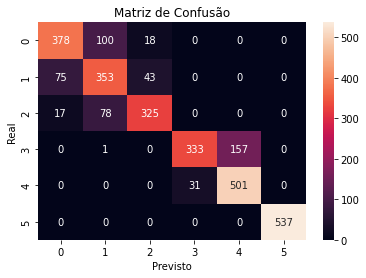

              precision    recall  f1-score   support

           1       0.80      0.76      0.78       496
           2       0.66      0.75      0.70       471
           3       0.84      0.77      0.81       420
           4       0.91      0.68      0.78       491
           5       0.76      0.94      0.84       532
           6       1.00      1.00      1.00       537

    accuracy                           0.82      2947
   macro avg       0.83      0.82      0.82      2947
weighted avg       0.83      0.82      0.82      2947



In [33]:
y_pred = clf.predict(X_teste)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_teste, y_pred)
print(conf_matrix)

# Visualizar a matriz de confusão
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# Relatório de classificação para ver a precisão por classe
print(classification_report(y_teste, y_pred))

### 5. Melhorando a árvore

A melhor forma de se melhorar um algoritmo é colocando nele novas variáveis que agreguem valor. Podemos usar a força-bruta e ir colocando variáveis aleatoriamente - ou colocar todas e deixar rodando por um bom tempo - ou utilizar uma lógica eficiente e fazer uma seleção de variáveis.

- Observe que há classes mais fáceis e mais difíceis de se identificar
- Crie uma variável binária para uma das classes de maior erro
- Faça uma árvore de classificação bem simples para esta variável:
    - utilize ```mean_samples_leaf=20```
    - utilize ```max_depth=4```
    - coloque todas as variáveis
- Observe a importância das variáveis, e selecione as 3 com maior importância
- Rode novamente o algoritmo acima com as 3 novas variáveis e avalie a acurácia

In [36]:
from sklearn.metrics import accuracy_score

# Criar uma variável binária para a classe com alto índice de erro
y_train_bin = (y_train == 4).astype(int) 

# Treinar a Árvore de decisão simples
clf_simple = DecisionTreeClassifier(min_samples_leaf=20, max_depth=4)
clf_simple.fit(X_train, y_train_bin)

# Obter e selecionar as três variáveis mais importantes
importances = clf_simple.feature_importances_
indices = np.argsort(importances)[::-1][:3]
top_features = X_train.columns[indices]

print(f'top 3 features: {top_features}')

#  Refinar o modelo usando apenas as três variáveis mais importantes
X_train_top3 = X_train[top_features]
X_test_top3 = X_teste[top_features]

# reinar novamente com as top 3 variáveis
clf_refined = DecisionTreeClassifier(min_samples_leaf=20, max_depth=4)
clf_refined.fit(X_train_top3, y_train_bin)

# Criar a variável binária para y_teste para a Classe 4
y_teste_bin = (y_teste == 4).astype(int)

# Avaliar a acurácia do modelo refinado
y_pred_top3 = clf_refined.predict(X_test_top3)
accuracy_top3 = accuracy_score(y_teste_bin, y_pred_top3)
print("Acurácia do modelo para a Classe 4:", accuracy_top3)


top 3 features: Index(['Unnamed: 52', 'Unnamed: 53', 'Unnamed: 468'], dtype='object')
Acurácia do modelo para a Classe 4: 0.9379029521547336
